# Network Models for Neural Encoding
This Jupyter Notebook runs a series of encoding models to predict the spike rate of a cell in primary visual cortex in response to a stimulus. Required external libraries: Tensorflow, Keras, Numpy, Matplotlib. 

Author: Ted Moskovitz, 2017

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import Activations
reload(Activations)
import Models
reload(Models)
import Performance
reload(Performance)

# set plots inside notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

This is a custom nonlinear activation function, defined as $2 \times sigmoid(x)$. This function is meant to account for the possibility of multiple spikes per time bin. 

In [2]:
big_sig = Activations.big_sig
exp = Activations.exp

**Flicker Data**

This particular dataset, adapted from Pillow et al. 2005, contains the spiking responses of an 'ON' macaque retinal ganglion cell stimulated by a binary flicker stimulus. Input data consists of the flicker stimulus itself, with the binned spike train as the target data. 

In [3]:
X_train = np.genfromtxt('xtrain.csv', delimiter=",")
y_train = np.genfromtxt('ytrain.csv', delimiter=",")
X_val = np.genfromtxt('xval.csv', delimiter=",")
y_val = np.genfromtxt('yval.csv', delimiter=",")
X_test = np.genfromtxt('xtest.csv', delimiter=",")
y_test = np.genfromtxt('ytest.csv', delimiter=",")
data = X_train, y_train, X_val, y_val, X_test, y_test
for s in data:
    print s.shape

(37000, 20)
(37000,)
(5000, 20)
(5000,)
(10500, 20)
(10500,)


Hold onto losses, predictions, likelihoods, and r-squared values. In this case, we use the Poisson loss function, governed by $L(y,\hat(y)) = \frac{1}{N} \sum_{i = 1}^{N} \hat{y}`_{i}` - y`_{i}`\log\hat{y}_{i}`$, where $\hat{y}$ are the model predictions, $y$ are the targets, and $N$ is the number of inputs. 

In [4]:
losses = {}
preds = {}
negloglis = {}
r2s = {}

In [5]:
def addPerformance(name, model, reshape=False):
    '''
    add and print performances (only for Keras network models) to appropriate dictionaries 
    '''
    preds[name] = Performance.getPreds(model, X_test, reshape)
    losses[name] = Performance.calcLoss(preds[name], y_test)
    negloglis[name] = Performance.getNegLogLi(preds[name], y_test)
    r2s[name] = Performance.getR2(preds[name], y_test)
    print name +  ' Results:'
    print 'Loss: ' + str(losses[name])
    print 'Negative Log-Likelihood: ' + str(negloglis[name])
    print 'r-squared: ' + str(r2s[name])

**Baseline Model**

This model simply calculates the average spike rate across all time bins in the training set and predicts that value for every time bin in the test set.

In [6]:
preds['Baseline'] = Models.getBaseline(y_train, y_test)
losses['Baseline'] = Performance.calcLoss(preds['Baseline'], y_test)
negloglis['Baseline'] = Performance.getNegLogLi(preds['Baseline'], y_test)
r2s['Baseline'] = Performance.getR2(preds['Baseline'], y_test)
print 'Baseline Results:'
print 'Loss: ' + str(losses['Baseline'])
print 'Negative Log-Likelihood: ' + str(negloglis['Baseline'])
print 'r-squared: ' + str(r2s['Baseline'])

Baseline Results:
Loss: 0.541343760053
Negative Log-Likelihood: 5684.10948056
r-squared: 1.62670206015e-35


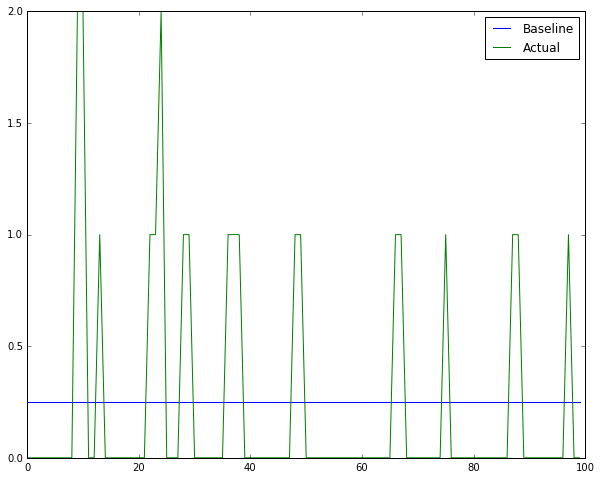

In [7]:
Performance.visualize(preds, preds.keys(), y_test)

**GLM**

A generalized linear model. Below we plot the spike-triggered average of the data, which we expect the filter weights to recover. 

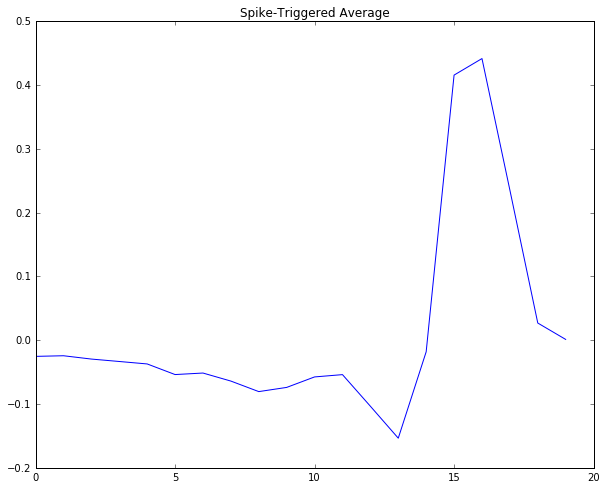

In [8]:
GLM = Models.buildGLM(data)
plt.plot(Models.getSTA(data))
plt.title('Spike-Triggered Average')
plt.show()

Results:

In [9]:
preds['GLM'], losses['GLM'] = Models.runGLM(GLM, data)
negloglis['GLM'] = Performance.getNegLogLi(preds['GLM'], y_test)
r2s['GLM'] = Performance.getR2(preds['GLM'], y_test)
print 'GLM Results:'
print 'Loss: ' + str(losses['GLM'])
print 'Negative Log-Likelihood: ' + str(negloglis['GLM'])
print 'r-squared: ' + str(r2s['GLM'])

GLM Results:
Loss: 0.306105189595
Negative Log-Likelihood: 3214.10449074
r-squared: 0.540689682257


**Fully Connected Net**

A two-layer fully connected (feedforward) neural network. Learning rate decay and Poisson loss. 

In [12]:
FCnet = Models.buildFC(nlin=big_sig)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 128)           2688        dense_input_2[0][0]              
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 64)            8256        dense_4[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 1)             65          dense_5[0][0]                    
Total params: 11009
____________________________________________________________________________________________________
None


Train on 37000 samples, validate on 5000 samples
Epoch 1/15
2s - loss: 0.5650 - mean_squared_error: 0.2952 - val_loss: 0.4640 - val_mean_squared_error: 0.2371
Epoch 2/15
2s - loss: 0.4494 - mean_squared_error: 0.2257 - val_loss: 0.3428 - val_mean_squared_error: 0.1652
Epoch 3/15
2s - loss: 0.3560 - mean_squared_error: 0.1590 - val_loss: 0.2940 - val_mean_squared_error: 0.1285
Epoch 4/15
2s - loss: 0.3311 - mean_squared_error: 0.1406 - val_loss: 0.2848 - val_mean_squared_error: 0.1206
Epoch 5/15
2s - loss: 0.3258 - mean_squared_error: 0.1381 - val_loss: 0.2942 - val_mean_squared_error: 0.1319
Epoch 6/15
2s - loss: 0.3245 - mean_squared_error: 0.1392 - val_loss: 0.2953 - val_mean_squared_error: 0.1364
Epoch 7/15
1s - loss: 0.3233 - mean_squared_error: 0.1391 - val_loss: 0.2815 - val_mean_squared_error: 0.1231
Epoch 8/15
2s - loss: 0.3230 - mean_squared_error: 0.1389 - val_loss: 0.2836 - val_mean_squared_error: 0.1256
Epoch 9/15
2s - loss: 0.3229 - mean_squared_error: 0.1394 - val_loss: 0

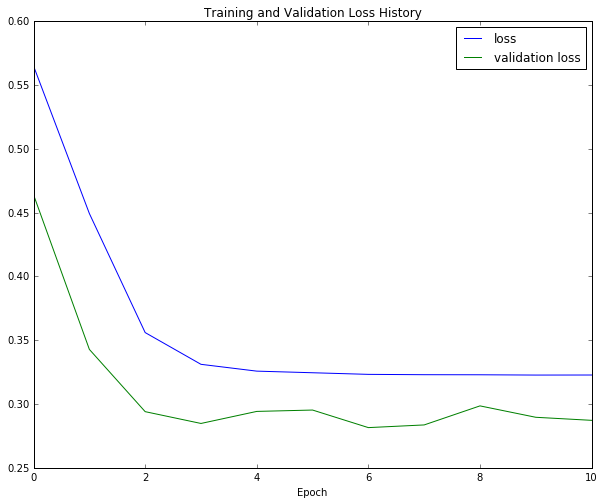

In [13]:
FC_hist, FC_lm = Models.runModel(FCnet, data, epoch=15)
Performance.vis_metrics(FC_hist)

In [14]:
addPerformance('FC', FCnet)

FC Results:
Loss: 0.287165174458
Negative Log-Likelihood: 3015.23433181
r-squared: 0.56691505475


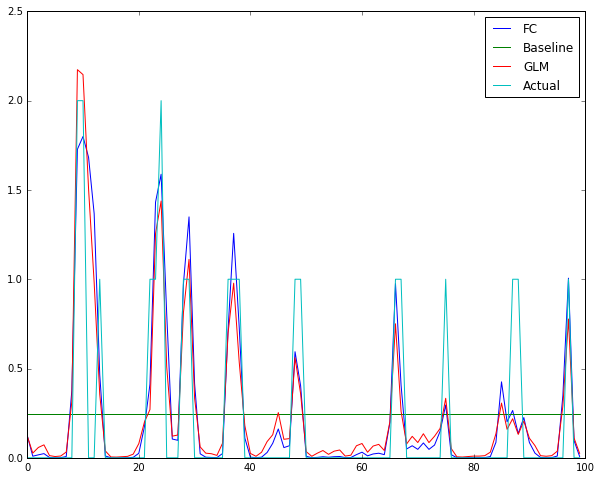

In [15]:
Performance.visualize(preds, preds.keys(), y_test)

**Zero Layer Nets**

We apply two 'zero-layer' networks, simply of the form $z = f(W\vec{x} + \vec{b})$, where $f$ is a nonlinearity. We expect the model with exponential nonlinearity to match the GLM performance. 

Sigmoid nonlinearity: 

In [16]:
sig0 = Models.buildZero(nlin=Activations.big_sig)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_7 (Dense)                  (None, 1)             21          dense_input_3[0][0]              
Total params: 21
____________________________________________________________________________________________________
None


Train on 37000 samples, validate on 5000 samples
Epoch 1/15
1s - loss: 0.6818 - mean_squared_error: 0.4414 - val_loss: 0.4749 - val_mean_squared_error: 0.2291
Epoch 2/15
1s - loss: 0.4619 - mean_squared_error: 0.2267 - val_loss: 0.3893 - val_mean_squared_error: 0.1771
Epoch 3/15
1s - loss: 0.4050 - mean_squared_error: 0.1896 - val_loss: 0.3538 - val_mean_squared_error: 0.1542
Epoch 4/15
1s - loss: 0.3781 - mean_squared_error: 0.1708 - val_loss: 0.3350 - val_mean_squared_error: 0.1420
Epoch 5/15
1s - loss: 0.3629 - mean_squared_error: 0.1599 - val_loss: 0.3235 - val_mean_squared_error: 0.1349
Epoch 6/15
1s - loss: 0.3532 - mean_squared_error: 0.1529 - val_loss: 0.3154 - val_mean_squared_error: 0.1306
Epoch 7/15
1s - loss: 0.3480 - mean_squared_error: 0.1495 - val_loss: 0.3124 - val_mean_squared_error: 0.1291
Epoch 8/15
2s - loss: 0.3453 - mean_squared_error: 0.1477 - val_loss: 0.3099 - val_mean_squared_error: 0.1278
Epoch 9/15
2s - loss: 0.3429 - mean_squared_error: 0.1463 - val_loss: 0

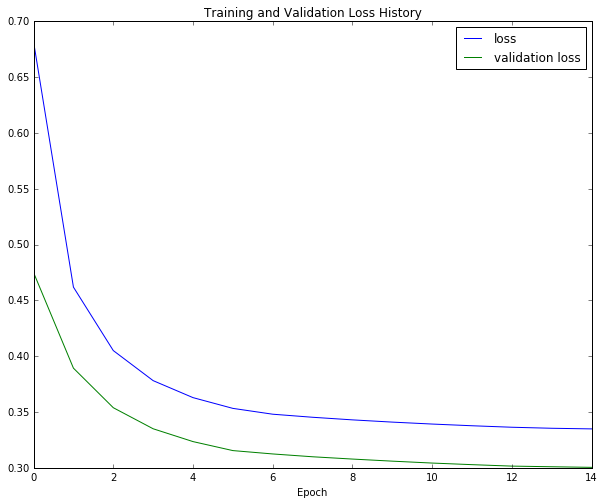

In [17]:
sig0_hist, sig0_lm = Models.runModel(sig0, data)
Performance.vis_metrics(sig0_hist)

In [18]:
addPerformance('sig0', sig0)

sig0 Results:
Loss: 0.302105309941
Negative Log-Likelihood: 3172.10575438
r-squared: 0.559035811738


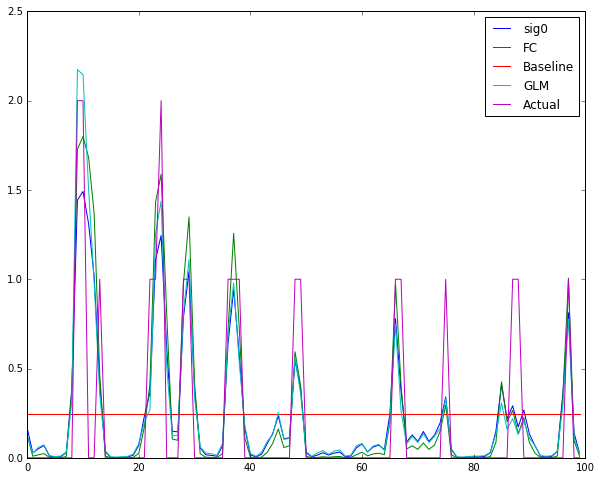

In [19]:
Performance.visualize(preds, preds.keys(), y_test)

Exponential Nonlinearity: 

In [21]:
exp0 = Models.buildZero(nlin=exp)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_9 (Dense)                  (None, 1)             21          dense_input_5[0][0]              
Total params: 21
____________________________________________________________________________________________________
None


Train on 37000 samples, validate on 5000 samples
Epoch 1/15
2s - loss: 0.5717 - mean_squared_error: 0.3503 - val_loss: 0.4076 - val_mean_squared_error: 0.1838
Epoch 2/15
1s - loss: 0.4081 - mean_squared_error: 0.1816 - val_loss: 0.3503 - val_mean_squared_error: 0.1416
Epoch 3/15
2s - loss: 0.3697 - mean_squared_error: 0.1518 - val_loss: 0.3291 - val_mean_squared_error: 0.1305
Epoch 4/15
2s - loss: 0.3543 - mean_squared_error: 0.1431 - val_loss: 0.3174 - val_mean_squared_error: 0.1284
Epoch 5/15
1s - loss: 0.3469 - mean_squared_error: 0.1414 - val_loss: 0.3108 - val_mean_squared_error: 0.1283
Epoch 6/15
1s - loss: 0.3428 - mean_squared_error: 0.1417 - val_loss: 0.3073 - val_mean_squared_error: 0.1296
Epoch 7/15
2s - loss: 0.3409 - mean_squared_error: 0.1420 - val_loss: 0.3063 - val_mean_squared_error: 0.1307
Epoch 8/15
1s - loss: 0.3399 - mean_squared_error: 0.1424 - val_loss: 0.3050 - val_mean_squared_error: 0.1309
Epoch 9/15
1s - loss: 0.3392 - mean_squared_error: 0.1426 - val_loss: 0

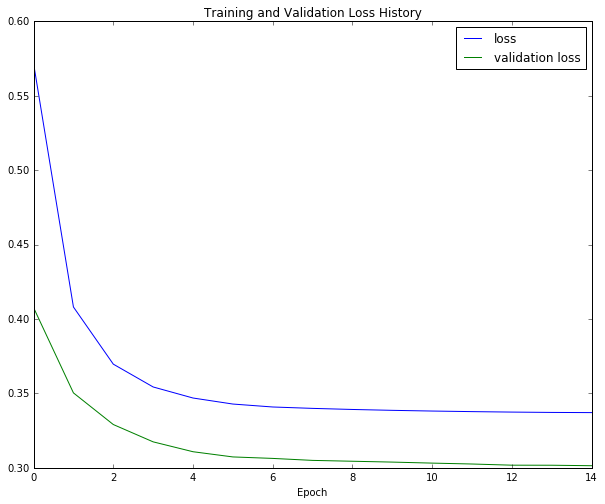

In [22]:
exp0_hist, exp0_lm = Models.runModel(exp0, data)
Performance.vis_metrics(exp0_hist)

In [25]:
addPerformance('exp0', exp0)

exp0 Results:
Loss: 0.303259892874
Negative Log-Likelihood: 3184.22887518
r-squared: 0.539575949047


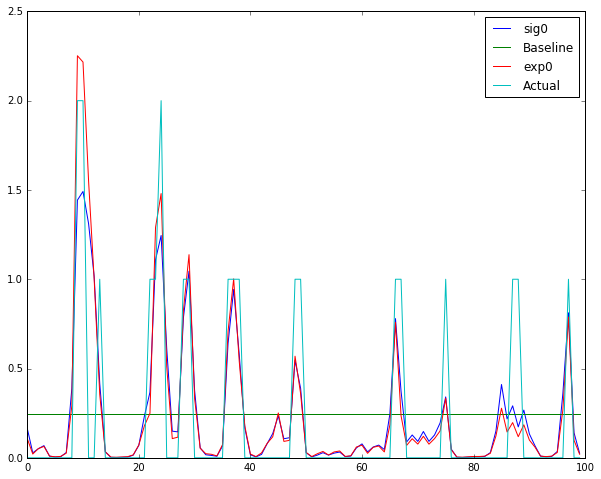

In [26]:
subset = ['Baseline', 'sig0', 'exp0']
Performance.visualize(preds, subset, y_test)

As predicted, the weights of the exponential network recapture the GLM filter weights:

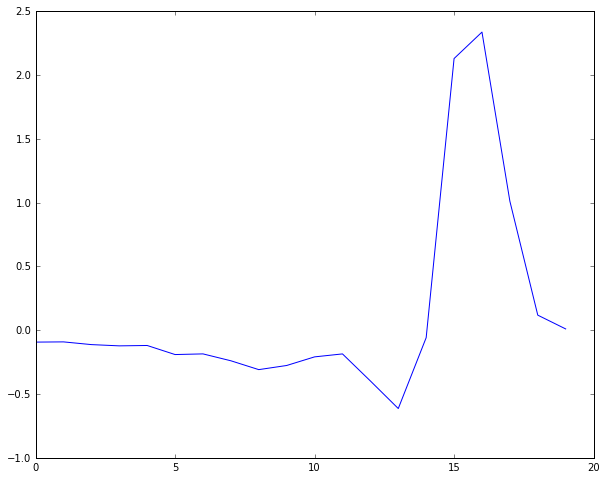

In [27]:
exp_wts, _ = Models.getWts(exp0)
plt.plot(exp_wts)
plt.show()

**Vanilla Recurrent Network**

A standard recurrent network with one layer. Note: this may run slowly on a personal computer. 

In [29]:
RNN = Models.buildRNN(nlin=big_sig)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
simplernn_1 (SimpleRNN)          (None, 64)            4224        simplernn_input_1[0][0]          
____________________________________________________________________________________________________
dense_10 (Dense)                 (None, 64)            4160        simplernn_1[0][0]                
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 64)            4160        dense_10[0][0]                   
____________________________________________________________________________________________________
dense_12 (Dense)                 (None, 1)             65          dense_11[0][0]                   
Total params: 12609
_______________________________________________________________________

Train on 37000 samples, validate on 5000 samples
Epoch 1/15
48s - loss: 0.4409 - mean_squared_error: 0.2178 - val_loss: 0.2904 - val_mean_squared_error: 0.1189
Epoch 2/15
23s - loss: 0.3112 - mean_squared_error: 0.1274 - val_loss: 0.2619 - val_mean_squared_error: 0.1035
Epoch 3/15
24s - loss: 0.3020 - mean_squared_error: 0.1202 - val_loss: 0.2649 - val_mean_squared_error: 0.1056
Epoch 4/15
28s - loss: 0.2984 - mean_squared_error: 0.1178 - val_loss: 0.2579 - val_mean_squared_error: 0.1020
Epoch 5/15
27s - loss: 0.2962 - mean_squared_error: 0.1151 - val_loss: 0.2729 - val_mean_squared_error: 0.1172
Epoch 6/15
27s - loss: 0.2944 - mean_squared_error: 0.1136 - val_loss: 0.2566 - val_mean_squared_error: 0.1015
Epoch 7/15
30s - loss: 0.2932 - mean_squared_error: 0.1127 - val_loss: 0.2548 - val_mean_squared_error: 0.1001
Epoch 8/15
25s - loss: 0.2921 - mean_squared_error: 0.1121 - val_loss: 0.2564 - val_mean_squared_error: 0.1020
Epoch 9/15
24s - loss: 0.2916 - mean_squared_error: 0.1112 - va

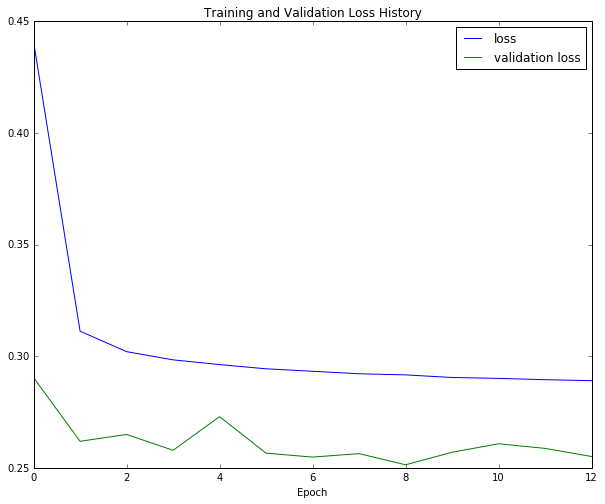

In [30]:
RNN_hist, RNN_lm = Models.runModel(RNN, data, reshape=True)
Performance.vis_metrics(RNN_hist)

In [32]:
addPerformance('RNN', RNN, reshape=True)

RNN Results:
Loss: 0.2660639279
Negative Log-Likelihood: 2793.67124295
r-squared: 0.597067985596


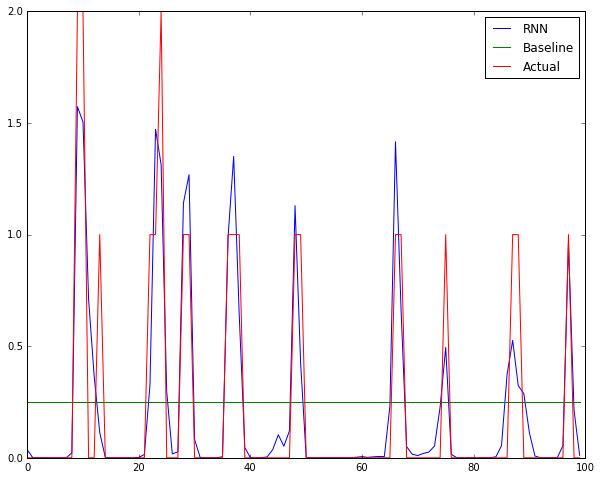

In [33]:
subset = ['Baseline', 'RNN']
Performance.visualize(preds, subset, y_test)

**LSTM**

A single layer long-short term memory network. Note: this will run slowly on a personal computer. 

In [34]:
LSTM = Models.buildLSTM(nlin=big_sig)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 64)            16896       lstm_input_1[0][0]               
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 1)             65          lstm_1[0][0]                     
Total params: 16961
____________________________________________________________________________________________________
None


In [16]:
LSTM_hist, LSTM_lm = Models.runModel(LSTM, data, reshape=True)
Performance.vis_metrics(LSTM_hist)

Train on 37000 samples, validate on 5000 samples
Epoch 1/15


KeyboardInterrupt: 

In [ ]:
addPerformance('LSTM', LSTM)

**Convolutional Network** 

A single-layer convolutional network, organized for 1-D convolution. 

In [35]:
ConvNet = Models.buildConvNet(nlin=big_sig)

NameError: global name 'MaxPooling' is not defined

Train on 37000 samples, validate on 5000 samples
Epoch 1/15
3s - loss: 0.5865 - mean_squared_error: 0.3163 - val_loss: 0.4666 - val_mean_squared_error: 0.2278
Epoch 2/15
3s - loss: 0.4263 - mean_squared_error: 0.2077 - val_loss: 0.3255 - val_mean_squared_error: 0.1371
Epoch 3/15
3s - loss: 0.3414 - mean_squared_error: 0.1457 - val_loss: 0.2929 - val_mean_squared_error: 0.1217
Epoch 4/15
3s - loss: 0.3268 - mean_squared_error: 0.1367 - val_loss: 0.2891 - val_mean_squared_error: 0.1238
Epoch 5/15
3s - loss: 0.3238 - mean_squared_error: 0.1368 - val_loss: 0.2941 - val_mean_squared_error: 0.1331
Epoch 6/15
4s - loss: 0.3231 - mean_squared_error: 0.1381 - val_loss: 0.2911 - val_mean_squared_error: 0.1327
Epoch 7/15
3s - loss: 0.3229 - mean_squared_error: 0.1389 - val_loss: 0.2889 - val_mean_squared_error: 0.1318
Epoch 8/15
3s - loss: 0.3227 - mean_squared_error: 0.1392 - val_loss: 0.2893 - val_mean_squared_error: 0.1329
Epoch 9/15
3s - loss: 0.3227 - mean_squared_error: 0.1393 - val_loss: 0

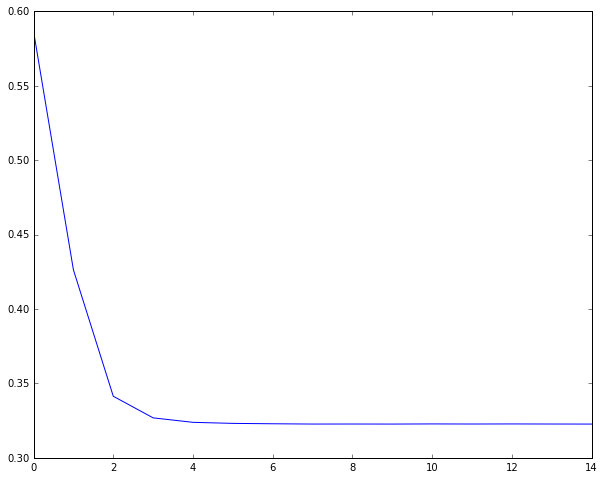

In [27]:
Conv_hist, Conv_lm = Models.runModel(ConvNet, data, reshape=True)
Performance.vis_metrics(Conv_hist)

In [31]:
addPerformance('ConvNet', ConvNet, reshape=True)

ConvNet Results:
Loss: 0.287976384994
Negative Log-Likelihood: 3023.75204243
r-squared: 0.566077565908


**Negative Log-Likelihood Comparison**

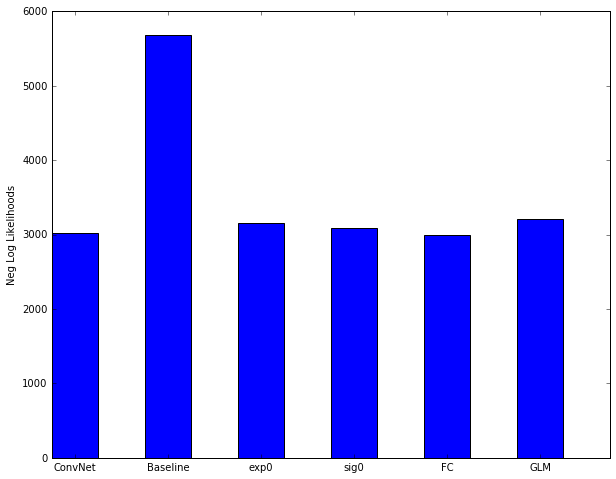

In [32]:
Performance.bar_comparison(negloglis, 'Neg Log Likelihoods')